## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import multiprocessing

In [2]:
#=====================================================================
#===================== Lectura y manipulacion ========================
#=====================================================================
df4 = pd.read_csv("Precio_viviendas_lima_peru_by_AQC.csv")
from scipy.stats.mstats import winsorize
df4['Precio_filtrado'] = winsorize(df4['Precio'], limits=[0.01, 0.01])

In [ ]:
import numpy as np
df4['Precio_sqrt'] = np.sqrt(df4['Precio_filtrado'])

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(df4['Precio_sqrt'].values.reshape(-1,1)).ravel()

In [ ]:
X = df4.drop(columns=['Unnamed: 0', 'Precio', 'Precio_filtrado', 'Precio_sqrt'])
y = y_scaled


## Moddelamiento con libreria SCIKIT - LEARN

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Tipo de Propiedad', 'Estado', 'Zona_macro']
num_cols = ['Dormitorios', 'Baños', 'Garajes', 'M² edificados']

from sklearn.preprocessing import RobustScaler
numeric_transformer = Pipeline([('scaler', RobustScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = Pipeline([
    ('preprocessing', preprocessor),
    ('modelo', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        early_stopping=True,
        max_iter=1500,
        random_state=42
    ))
])
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Dormitorios', 'Baños',
                                                   'Garajes',
                                                   'M² edificados']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Tipo de Propiedad',
                                                   'Estado', 'Zona_macro'])])),
                ('modelo',
                 MLPRegressor(alpha=0.001, early_stopping=True,
                              hidden_layer_sizes=(128, 64, 32),
                              learning_rate='adaptive', max_iter=1500,
                              random_state=42))])

In [13]:
y_pred_scaled = model.predict(X_test)
from sklearn.metrics import r2_score, mean_absolute_error

# Revertir la raíz cuadrada y el escalado
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel() ** 2
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel() ** 2

print("R²:", r2_score(y_test_real, y_pred))
print("MAE:", mean_absolute_error(y_test_real, y_pred))


R²: 0.5483790986692693
MAE: 284526.58535795345


In [15]:
# Comaration
df_temp = pd.DataFrame({'Actual': y_test_real, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
0,185000.0,146464.198570
1,540000.0,506658.885167
2,540000.0,506658.885167
3,133000.0,131070.243558
4,962000.0,727259.449791


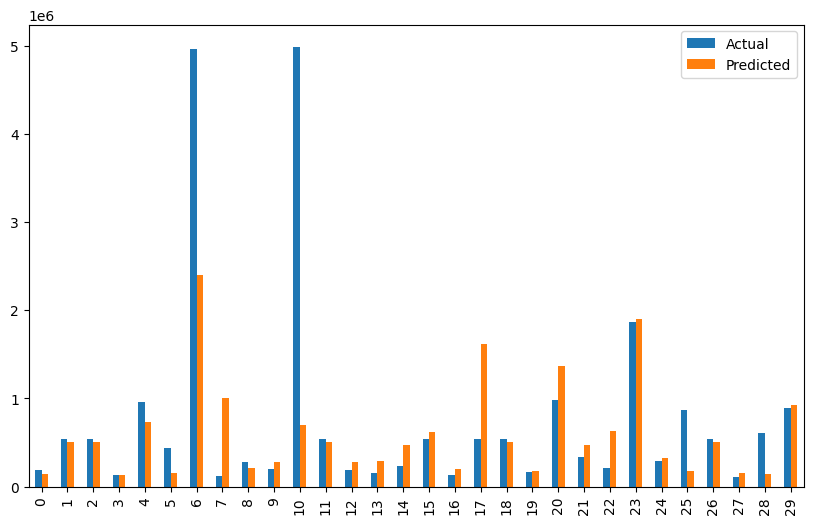

In [16]:
# Graphic
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.show()

In [ ]:
# Espacio de búsqueda
param_distributions = {
    'modelo__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'modelo__alpha': np.logspace(-5, 1, 10),
    'modelo__learning_rate_init': [0.0005, 0.001, 0.01],
    'modelo__activation': ['relu', 'tanh'],
    'modelo__solver': ['adam', 'lbfgs']
}

# RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=5,
    verbose=0,
    random_state=100,
    return_train_score=True
)

# Entrenamiento
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Dormitorios',
                                                                                'Baños',
                                                                                'Garajes',
                                                                                'M² '
                                                                                'edificados']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Tipo '
                                                                                'de '
                                                                                'Propiedad',
                                                                                'Estado',
                                                                                'Zona_macro'])])),
                                             ('modelo',
                                              MLPRegressor(...
                                        'modelo__alpha': array([1.00000000e-05, 4.64158883e-05, 2.15443469e-04, 1.00000000e-03,
       4.64158883e-03, 2.15443469e-02, 1.00000000e-01, 4.64158883e-01,
       2.15443469e+00, 1.00000000e+01]),
                                        'modelo__hidden_layer_sizes': [(64,),
                                                                       (128,),
                                                                       (64, 32),
                                                                       (128,
                                                                        64),
                                                                       (128, 64,
                                                                        32)],
                                        'modelo__learning_rate_init': [0.0005,
                                                                       0.001,
                                                                       0.01],
                                        'modelo__solver': ['adam', 'lbfgs']},
                   random_state=100, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [37]:
# Evaluación
best_model = grid_search.best_estimator_
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() ** 2
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel() ** 2

from sklearn.metrics import r2_score, mean_squared_error
print("R²:", r2_score(y_test_real, y_pred))
print("RMSE:", mean_squared_error(y_test_real, y_pred, )**(1/2))

R²: 0.5410697506658086
RMSE: 632799.4321637574


In [46]:
df_temp1 = pd.DataFrame({'Actual': y_test_real, 'Predicted': y_pred})
df_temp1.head()

,Actual,Predicted
0,185000.0,188580.897359
1,540000.0,534638.597247
2,540000.0,534638.597247
3,133000.0,140889.100308
4,962000.0,735956.429622


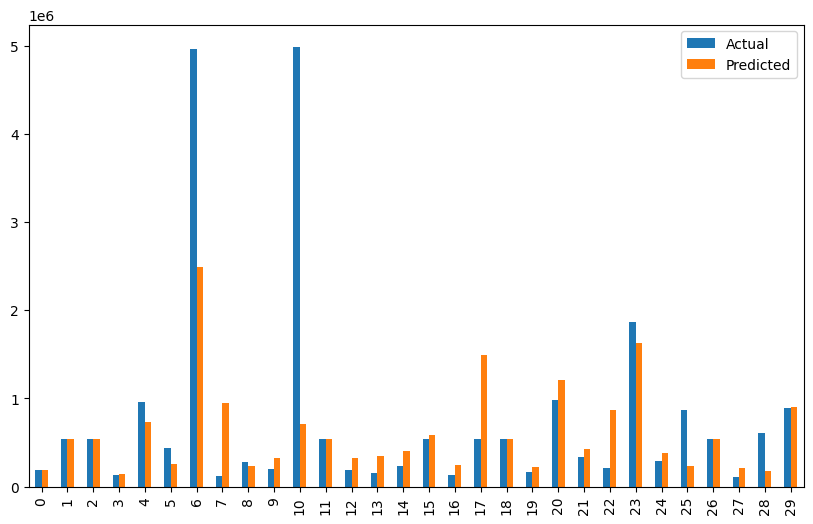

In [45]:
df_temp = df_temp1.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.show()

In [ ]:
# df4.columns
col_cat=df4.select_dtypes(include=['object', 'category']).columns.tolist()
print(col_cat)
for col in col_cat:
    print("-----------------------------------------------------------")
    print(f"Distribución de '{col}':")
    print(df4[col].value_counts(normalize=True).round(3))

['Tipo de Propiedad', 'Estado', 'Zona_macro']
-----------------------------------------------------------
Distribución de 'Tipo de Propiedad':
Tipo de Propiedad
Casa            0.578
Departamento    0.422
Name: proportion, dtype: float64
-----------------------------------------------------------
Distribución de 'Estado':
Estado
Buen estado         0.470
Excelente estado    0.399
Otro                0.131
Name: proportion, dtype: float64
-----------------------------------------------------------
Distribución de 'Zona_macro':
Zona_macro
Lima Centro    0.622
Lima Sur       0.240
Lima Norte     0.058
Otros          0.035
Lima Este      0.030
Callao         0.016
Name: proportion, dtype: float64


In [80]:
## Result
input_df = pd.DataFrame({
    'Dormitorios': [2],
    'Baños': [2],
    'Garajes': [1],
    'M² edificados': [50],
    'Tipo de Propiedad':['Casa'],
    'Estado': ["Excelente estado"],
    'Zona_macro': ["Lima Norte"]})
predicciones = best_model.predict(X = input_df)
# 2. Desescalar con el scaler original
pred_sqrt = scaler_y.inverse_transform(predicciones.reshape(-1, 1)).ravel()

# 3. Deshacer la raíz cuadrada (inversa de np.sqrt)
precio_final = pred_sqrt ** 2

print(f"Precio predicho: USD $ {precio_final[0]:,.2f}")

Precio predicho: USD $ 108,262.56


## Modelamiento con la librería PYtorch

In [ ]:
# !pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/216.1 MB 1.5 MB/s eta 0:02:23
   ---------------------------------------- 1.3/216.1 MB 1.9 MB/s eta 0:01:55
   ---------------------------------------- 1.8/216.1 MB 2.1 MB/s eta 0:01:45
   ---------------------------------------- 2.4/216.1 MB 2.1 MB/s eta 0:01:42
    --------------------------------------- 2.9/216.1 MB 2.1 MB/s eta 0:01:40
    --------------------------------------- 3.1/216.1 MB 2.2 MB/s eta 0:01:38
    --------------------------------------- 3.7/216.1 MB 2.2 MB/s eta 0:01:36
    --------------------------------------- 4.2/216.1 MB 2.2 MB/s eta 0:01:37
    --------------------------------------- 4.7/216.1 MB 2.2 MB/s eta 0:01:36
    ---


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
import torch
from torch.utils.data import DataLoader, TensorDataset

In [87]:
# Columnas
cat_cols = ['Tipo de Propiedad', 'Estado', 'Zona_macro']
num_cols = ['Dormitorios', 'Baños', 'Garajes', 'M² edificados']

# Preprocesamiento
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline([('scaler', RobustScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

X_processed = preprocessor.fit_transform(X)

In [89]:
# División y tensores
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [96]:
import torch.nn as nn
import torch.optim as optim

# Modelo
class PriceModel(nn.Module):
    def __init__(self, input_dim):
        super(PriceModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

model = PriceModel(X_train_tensor.shape[1])

# Entrenamiento
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(300):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluación
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy().ravel()

# Inverso de transformaciones
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() ** 2
y_test_real = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).ravel() ** 2

from sklearn.metrics import r2_score, mean_squared_error
print(f"R²: {r2_score(y_test_real, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test_real, y_pred)**(1/2):,.2f} dolares")


R²: 0.470
RMSE: 725,550.63 dolares


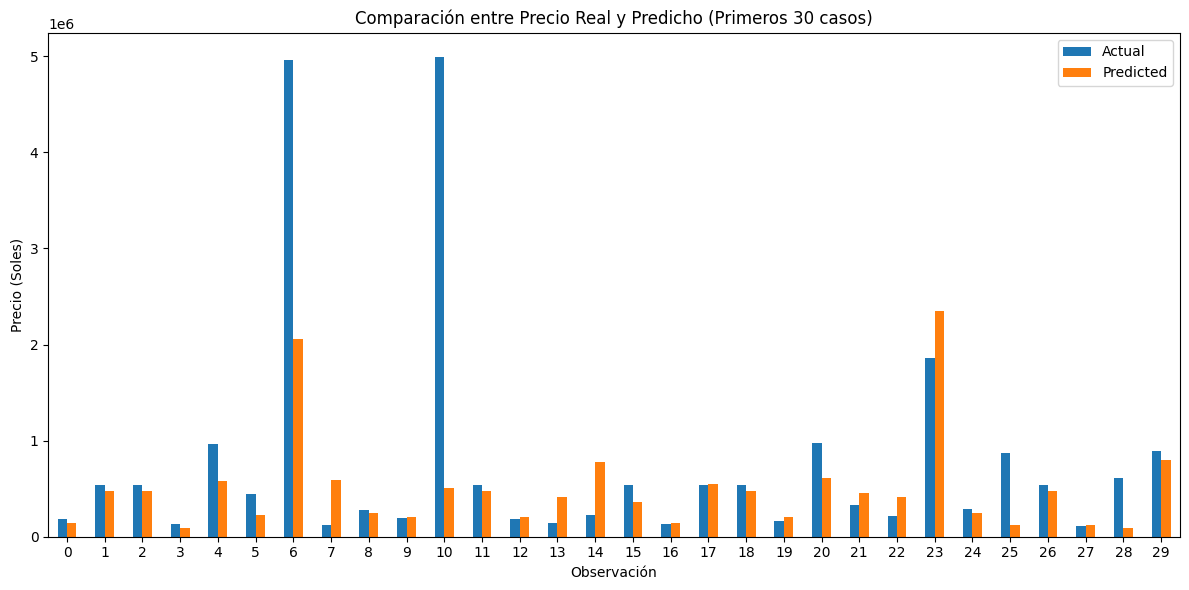

In [97]:

df_temp = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred
})

df_temp_subset = df_temp.head(30)
df_temp_subset.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title("Comparación entre Precio Real y Predicho (Primeros 30 casos)")
plt.ylabel("Precio (Soles)")
plt.xlabel("Observación")
plt.tight_layout()
plt.show()

-------------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
from sklearn.metrics import r2_score, mean_squared_error

# ------------------ Combinaciones a probar ------------------
hidden_sizes = [(64,), (128, 64), (128, 64, 32)]
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}
lrs = [0.001, 0.005]
weight_decays = [0.0, 0.01]

# ------------------ Guardar mejores resultados ------------------
best_r2 = -np.inf
best_config = None
best_model = None

In [ ]:
# ------------------ Tuning loop ------------------
for h_layers, act_name, lr, wd in product(hidden_sizes, activations.keys(), lrs, weight_decays):
    
    class TunedModel(nn.Module):
        def __init__(self, input_dim):
            super(TunedModel, self).__init__()
            layers = []
            last_dim = input_dim
            for h in h_layers:
                layers.append(nn.Linear(last_dim, h))
                layers.append(activations[act_name])
                last_dim = h
            layers.append(nn.Linear(last_dim, 1))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    model = TunedModel(X_train_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Entrenar
    for epoch in range(150):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluar
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy().ravel()

    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() ** 2
    y_test_real = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).ravel() ** 2
    r2 = r2_score(y_test_real, y_pred)

    # Guardar si mejora
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_config = {
            'hidden_layers': h_layers,
            'activation': act_name,
            'lr': lr,
            'weight_decay': wd
        }

🔍 Mejor configuración:
{'hidden_layers': (128, 64), 'activation': 'relu', 'lr': 0.005, 'weight_decay': 0.01}
✅ Mejor R²: 0.595


In [94]:
# ------------------ Resultado final ------------------
print("🔍 Mejor configuración:")
print(best_config)

print(f"✅ Mejor R²: {best_r2:.3f}")


🔍 Mejor configuración:
{'hidden_layers': (128, 64), 'activation': 'relu', 'lr': 0.005, 'weight_decay': 0.01}
✅ Mejor R²: 0.595


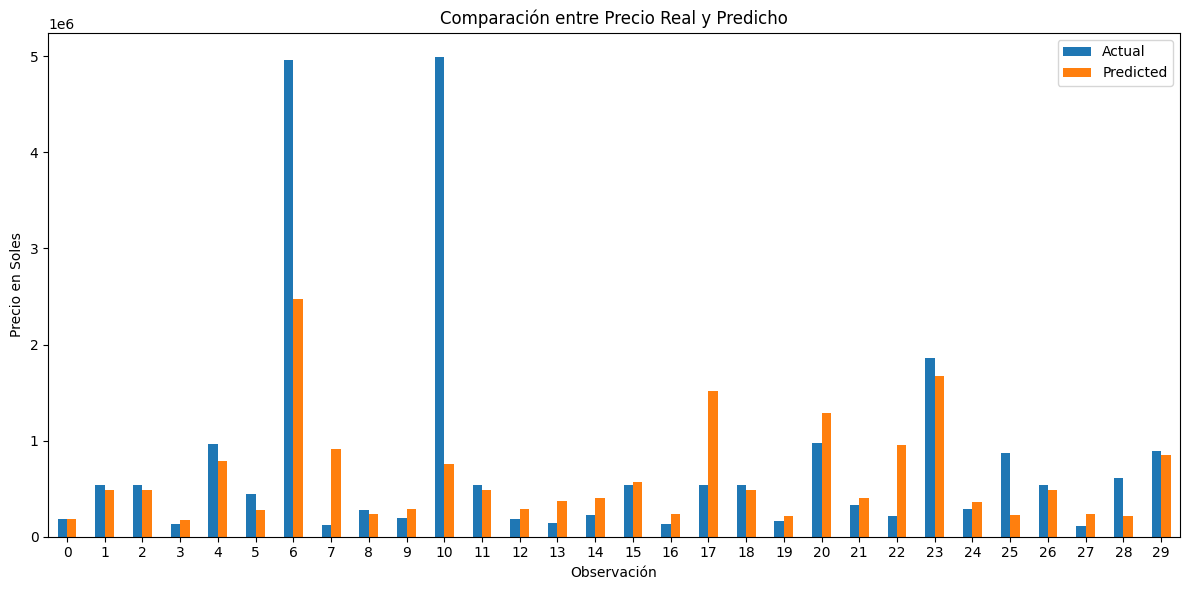

In [93]:
# Asegúrate de tener y_pred y y_test_real ya calculados con el mejor modelo
df_temp = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred
})

# Seleccionamos los primeros 30 para visualizar
df_temp_subset = df_temp.head(30)

# Crear gráfico de barras
df_temp_subset.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title("Comparación entre Precio Real y Predicho")
plt.ylabel("Precio en Soles")
plt.xlabel("Observación")
plt.tight_layout()
plt.show()


## Comparacion de metricas

In [102]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

# Suponiendo que ya tienes y_test_real y y_pred para PyTorch
r2_sklearn = 0.541
rmse_sklearn = 686381.69

r2_pytorch = 0.595
rmse_pytorch = mean_squared_error(y_test_real, y_pred)**(1/2)

df_metrics = pd.DataFrame({
    'Modelo': ['Scikit-learn MLPRegressor', 'PyTorch Red Neuronal'],
    'R²': [r2_sklearn, r2_pytorch],
    'RMSE (Dolares)': [rmse_sklearn, rmse_pytorch]
})

print(df_metrics)


                      Modelo     R²  RMSE (Dolares)
0  Scikit-learn MLPRegressor  0.541   686381.690000
1       PyTorch Red Neuronal  0.595   725550.632235


## Recursos para la interfaz

In [ ]:
#torch.save(model.state_dict(), "modelo_pytorch.pth")
#import joblib
#joblib.dump(modelo_final, "modelo_sklearn.pkl")


['modelo_sklearn.pkl']